In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
author_data = pd.read_csv("../data/raw/author_data.csv")
comment_data = pd.read_csv("../data/raw/comment_data.csv")
gilds_data = pd.read_csv("../data/raw/gildings_data.csv")
threads_data = pd.read_csv("../data/raw/thread_data.csv")

/home/jeevan/.local/share/virtualenvs/Programming-Files-01Pl4DQl/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0,3,4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Remove the duplicates - I had to run a modified version of the script since desktop kept shutting down (due to inclement weather; used append flag as a quick fix which resulted in all of the data being written multiple times).

In [3]:
def drop_duplicates_na(data, key_columns):
    '''Takes in data and key columns as parameters, in this case, key column refers to
    the columns to consider for identifying duplicates. Returns a dataframe where the 
    duplicates (all except for the last occurrence) and columns with NA are removed.'''
    df = data.copy()
    df.drop_duplicates(subset=key_columns, keep='last', inplace=True, ignore_index=True)
    return df.dropna()

In [4]:
authors_data = drop_duplicates_na(author_data, ['author_ids'])
comments_data = drop_duplicates_na(comment_data, ['comment_ids'])
gilds_data = drop_duplicates_na(gilds_data, ['comment_ids'])
threads_data = drop_duplicates_na(threads_data, ['thread_ids'])

In [5]:
from pathlib import Path

def save(df, savepath, filename):
    '''Takes in a dataframe and a filename for saving to csv'''
    Path(savepath).mkdir(parents=True, exist_ok=True) #Make the folder if it already doesn't exist
    df.to_csv(f"{savepath}{filename}.csv", index=False)

save(authors_data, "../data/interim/", "author_data")
save(comments_data, "../data/interim/", "comment_data")
save(gilds_data, "../data/interim/", "gildings_data")
save(threads_data, "../data/interim/", "threads_data")

In [6]:
from datetime import timedelta
import time

def toDays(x, currentime):
    '''Takes in created_utc time (Unix time, in seconds) and current time. Calculates
    age and returns the number of days'''
    d = timedelta(seconds=currentime-x)
    return d.days

def process_dates(data, new_column):
    '''Convert the created_utc time to datetime, fetch the days and place it
    in a new column. Also removes the original created_utc column'''
    df = data.copy()
    now = time.time() #This will differ everytime, but the change will be constant across all the rows.
    df[new_column] = df.created_utc.map(lambda x: toDays(x, now))
    return df.drop(["created_utc"], axis=1)
    
authors = process_dates(authors_data, "acc_age_days")
comments = process_dates(comments_data, "comment_age_days")

For a baseline model, we will work with binary classification (whether a comment is gilded or not). For that, we need to do slightly different transformations, and since there's a large imbalance (gilded vs not gilded comments), we will have to transform the full data and then use stratified sampling.

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

class gilds_binary(BaseEstimator, TransformerMixin):
    '''Using Sklearn's base transformer class to process the gildings column (convert the dictionary into binary)'''
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        df["gildings"].fillna(0, inplace=True)
        df["gildings"] = df["gildings"].apply(lambda x: 1 if x != 0 else 0)
        return df, pd.DataFrame(df["gildings"])

In [35]:
comment_gilds = gilds_data.merge(comments, how='outer', on='comment_ids')
comments_all = comment_gilds.merge(authors, how='inner', on='author_ids')

transform_gilds = gilds_binary()
comments_all, targets = transform_gilds.transform(comments_all)
all_data = comments_all '''.filter(items=["ups", "comment_karma", "link_karma", 
                                        "is_premium", "comment_age_days", "acc_age_days"], axis=1)'''

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

splits = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splits.split(all_data, targets):
    pass
X_train = all_data.iloc[train_index, :]
y_train = targets.iloc[train_index, :]
X_test = all_data.iloc[test_index, :]
y_test = targets.iloc[test_index, :]

In [37]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [38]:
train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [39]:
save(train_data, "../data/processed/", "train_data_baseline")
save(test_data, "../data/processed/", "test_data_baseline")

In [40]:
train_data

,comment_ids,gildings,comment_body,ups,downs,author_ids,edited,thread_ids,comment_age_days,comment_karma,link_karma,is_premium,acc_age_days,gildings
0,f9dboji,0,You honestly couldn't pay me to have one,-3.0,0.0,ph6et,False,e4kipy,170,63630,673,False,1743,0
1,flbk2xj,0,this is the only game that has taken over 5 mi...,556.0,0.0,3ngvpkt3,False,fntad4,56,9354,689,False,391,0
2,ecy27sg,0,Not if you’re blind! Ha! Checkmate apocalypse!,13.0,0.0,12f7uy,False,ab6ddf,505,72100,18305,False,1300,0
3,f89g8zx,0,You think these people were around for that lol?,2.0,0.0,31wio12y,False,dzn4yy,179,30401,561,False,483,0
4,fdnrjsu,0,This is such a hilariously bad take I don't ev...,11.0,0.0,5yrhb,False,ema7zh,131,155479,3020,False,3152,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511985,fclibdm,0,20/10,1.0,0.0,48lmatyt,False,eho2pf,140,0,1,False,293,0
511986,dpvg7pe,0,I'd say avoid games they pull this shit in. \n...,1.0,0.0,7r3yd,False,7d3iqg,916,96086,9216,False,2923,0
511987,eataiky,0,About a fox trying to survive in a post-apocal...,2.0,0.0,d3u5t,False,a1utd8,536,13429,9419,False,2442,0
511988,efwr1s6,0,I am overdrafted by £1.57.,1.0,0.0,15olsc,False,anspgf,467,54086,1845,False,1180,0


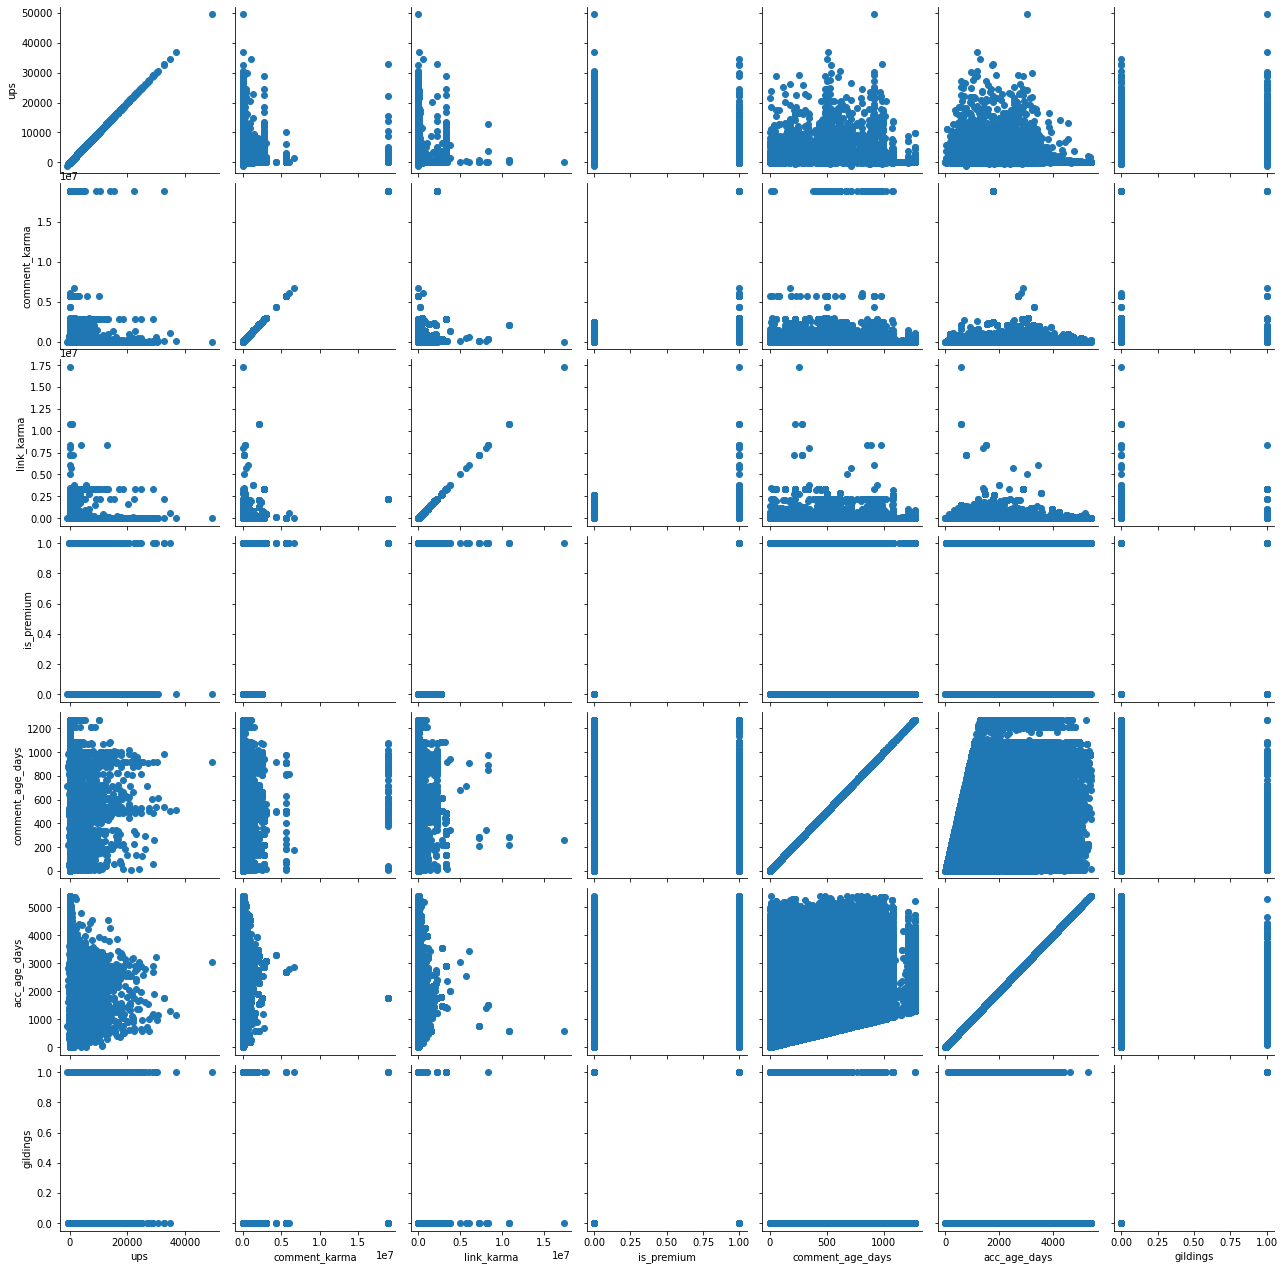

In [34]:
g = sns.PairGrid(train_data, vars=["gildings", "ups", "acc_age_days", "comment_karma", "link_karma"])
g.map(plt.scatter)